# POPTICS
step1.CLEAN THE RAW DATA TO THE CORRECT INPUT FORMAT OF POPTICS
step2.USE POPTICS TO EACH USER AND GET THE CLUSTERS OF EACH USER

In [6]:
l = []
w = []
class A:
    def __init__(self,a,b):
        self.a = a;
        self.b = b
# aa = A(-73.989450756723, 40.74481949770078)
# for i in range(100000):
#     l.append(aa)
bb = A(-73.989450756723, 40.74481949770079)
i = 3
while i > 0:
    if bb not in l:
        print("false")
        print(bb.a, bb.b)
        l.append(bb)
        w.append(1)
        print(l.index(bb))
    else:
        w[l.index(bb)] += 1
    print(w)
    i -= 1
print(l[0].a,l[0].b)

false
-73.989450756723 40.74481949770079
0
[1]
[2]
[3]
-73.989450756723 40.74481949770079


In [7]:
# Copyright (c) 2012, Ryan Gomba
# All rights reserved.
# 
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
# 
# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions and the following disclaimer. 
# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.
# 
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
# ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
# WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR
# ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
# (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
# LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND
# ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
# (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
# SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
# 
# The views and conclusions contained in the software and documentation are those
# of the authors and should not be interpreted as representing official policies, 
# either expressed or implied, of the FreeBSD Project.

import math
import json
import numpy as np
import functools

################################################################################
# POINT
################################################################################

class Point:
    
    def __init__(self, latitude, longitude):
        
        self.latitude = latitude
        self.longitude = longitude
        self.cd = None              # core distance
        self.rd = None              # reachability distance
        self.processed = False      # has this point been processed?
        
    def __eq__(self, other):
             if self.latitude == other.latitude and self.longitude==other.longitude:
                  return True
             else:
                  return False
        
    # --------------------------------------------------------------------------
    # calculate the distance between any two points on earth
    # --------------------------------------------------------------------------
    
    def distance(self, point):
        
        # convert coordinates to radians
        
        p1_lat, p1_lon, p2_lat, p2_lon = [math.radians(c) for c in
            [self.latitude, self.longitude, point.latitude, point.longitude]]
        
        numerator = math.sqrt(
            math.pow(math.cos(p2_lat) * math.sin(p2_lon - p1_lon), 2) +
            math.pow(
                math.cos(p1_lat) * math.sin(p2_lat) -
                math.sin(p1_lat) * math.cos(p2_lat) *
                math.cos(p2_lon - p1_lon), 2))

        denominator = (
            math.sin(p1_lat) * math.sin(p2_lat) +
            math.cos(p1_lat) * math.cos(p2_lat) *
            math.cos(p2_lon - p1_lon))
        
        # convert distance from radians to meters
        # note: earth's radius ~ 6372800 meters
        
        return math.atan2(numerator, denominator) * 6372800
        
    # --------------------------------------------------------------------------
    # point as GeoJSON
    # --------------------------------------------------------------------------
        
    def to_geo_json_dict(self, properties=None):
        
        return {
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': [
                    self.longitude,
                    self.latitude,
                ]
            },
            'properties': properties,
        }
 
    def __repr__(self):
        return '(%f, %f)' % (self.latitude, self.longitude)

################################################################################
# CLUSTER
################################################################################

class Cluster:
    
    def __init__(self, points):
        
        self.points = points
        self.center = 0
        self.radius = 0
        
    # --------------------------------------------------------------------------
    # calculate the centroid for the cluster
    # --------------------------------------------------------------------------

    def centroid(self):
        
        return Point(sum([p.latitude for p in self.points])/len(self.points),
            sum([p.longitude for p in self.points])/len(self.points))
            
    # --------------------------------------------------------------------------
    # calculate the region (centroid, bounding radius) for the cluster
    # --------------------------------------------------------------------------
    
    def region(self):
        
        centroid = self.centroid()
        radius = functools.reduce(lambda p1, p2: p1 if p1.distance(centroid) > p2.distance(centroid) else p2, self.points).distance(centroid)
        #radius = functools.reduce(lambda r, p: max(r, p.distance(centroid)), self.points)
        return centroid, radius
        
    # --------------------------------------------------------------------------
    # cluster as GeoJSON
    # --------------------------------------------------------------------------
        
    def to_geo_json_dict(self, user_properties=None):
        
        self.center, self.radius = self.region()
        properties = { 'radius': self.radius }
        if user_properties: properties.update(user_properties)
        
        return {
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': [
                    self.center.longitude,
                    self.center.latitude,
                ]
            },
            'properties': properties,
        }

################################################################################
# OPTICS
################################################################################

class Optics:
    
    def __init__(self, points, max_radius, min_cluster_size):
        
        self.points = points
        self.max_radius = max_radius                # maximum radius to consider
        self.min_cluster_size = min_cluster_size    # minimum points in cluster
        self.rd = []
    # --------------------------------------------------------------------------
    # get ready for a clustering run
    # --------------------------------------------------------------------------
    
    def _setup(self):
        
        for p in self.points:
            p.rd = None
            p.processed = False
        self.unprocessed = [p for p in self.points]
        self.ordered = []

    # --------------------------------------------------------------------------
    # distance from a point to its nth neighbor (n = min_cluser_size)
    # --------------------------------------------------------------------------
    
    def _core_distance(self, point, neighbors):
        if point.cd is not None: return point.cd
        if len(neighbors) >= self.min_cluster_size - 1:
            sorted_neighbors = sorted([n.distance(point) for n in neighbors])
            point.cd = sorted_neighbors[self.min_cluster_size - 2] # index(0 start and itself is in cluster)
            return point.cd
        
    # --------------------------------------------------------------------------
    # neighbors for a point within max_radius
    # --------------------------------------------------------------------------
    
    def _neighbors(self, point):
        
        return [p for p in self.points if p is not point and  #p is not itself
            p.distance(point) <= self.max_radius]
            
    # --------------------------------------------------------------------------
    # mark a point as processed
    # --------------------------------------------------------------------------
        
    def _processed(self, point):
    
        point.processed = True
        self.unprocessed.remove(point)
        self.ordered.append(point)
    
    # --------------------------------------------------------------------------
    # update seeds if a smaller reachability distance is found
    # --------------------------------------------------------------------------

    def _update(self, neighbors, point, seeds):
        
        # for each of point's unprocessed neighbors n...

        for n in [n for n in neighbors if not n.processed]:
            
            # find new reachability distance new_rd
            # if rd is null, keep new_rd and add n to the seed list
            # otherwise if new_rd < old rd, update rd
            
            new_rd = max(point.cd, point.distance(n))
            if n.rd is None:
                n.rd = new_rd
                seeds.append(n)
            elif new_rd < n.rd:
                n.rd = new_rd
    
    # --------------------------------------------------------------------------
    # run the OPTICS algorithm
    # --------------------------------------------------------------------------

    def run(self):
        
        self._setup()
        
        # for each unprocessed point (p)...
        
        while self.unprocessed:
            point = self.unprocessed[0]
            #point.rd = 0
            # mark p as processed
            # find p's neighbors
            
            self._processed(point)
            point_neighbors = self._neighbors(point)

            # if p has a core_distance, i.e has min_cluster_size - 1 neighbors

            if self._core_distance(point, point_neighbors) is not None:
                
                # update reachability_distance for each unprocessed neighbor
                
                seeds = []
                self._update(point_neighbors, point, seeds)
                
                # as long as we have unprocessed neighbors...
                
                while(seeds):
                    
                    # find the neighbor n with smallest reachability distance
                    
                    seeds.sort(key=lambda n: n.rd)
                    n = seeds.pop(0)
                    
                    # mark n as processed
                    # find n's neighbors
                    
                    self._processed(n)
                    n_neighbors = self._neighbors(n)
                    
                    # if p has a core_distance...
                    
                    if self._core_distance(n, n_neighbors) is not None:
                        
                        # update reachability_distance for each of n's neighbors
                        
                        self._update(n_neighbors, n, seeds)
        
        self.reset_rd();
        # when all points have been processed
        # return the ordered list

        return self.ordered
    
    def reset_rd(self):
        for point in self.ordered:
            point.rd = point.rd if point.rd else self.max_radius+100
            self.rd.append(point.rd) 
    # --------------------------------------------------------------------------
    # add score to decide the cluster_threshold
    def _score(self):
        N = len(self.rd)
        rd = [rd for rd in self.rd]
        #print(rd)
        #rd = [point.rd for point in self.ordered if point.rd is not None]
        rd.sort()
        #print(rd)
        rdth = 0
        min_score = np.inf
        #print(self.ordered)
        for i in range(len(self.rd)):
            if i >= self.min_cluster_size - 1:
                #print(np.std(rd[0:i]),N,i)
                score = np.std(rd[0:i])*(N/i);
                if score < min_score:
                    min_score = score
                    rdth = rd[i]
        #print(rdth)
        return rdth
        
    def cluster(self):
        
#         cd = []
#         for point in self.ordered:
#             if point.cd is not None:
#                 cd.append(point.cd)
#         #print(cd)
#         cd.sort()
        #print("2*cd_min: ", 2*cd[0])
        #print(self._score())
        #cluster_threshold = 2*cd[0]
        #cluster_threshold = 3000
        cluster_threshold = self._score()
        
        
        clusters = []
        separators = []
        
        for i in range(len(self.ordered)):
            this_i = i
            next_i = i + 1
            this_p = self.ordered[i]
            this_rd = this_p.rd if this_p.rd else float('infinity')
            # use an upper limit to separate the clusters
            
            if this_rd > cluster_threshold:
                separators.append(this_i)

        separators.append(len(self.ordered))
        #print(separators)

        for i in range(len(separators) - 1):
            start = separators[i]
            end = separators[i + 1]
            #print(end - start)
            if end - start >= self.min_cluster_size:
                clusters.append(Cluster(self.ordered[start:end]))
        for cluster in clusters:
            cluster.to_geo_json_dict()
            #print(cluster.center, cluster.radius)
        return clusters
    
    def bar(self):
        plt.bar(range(len(self.rd)),self.rd, width=1.0)
        plt.show()
#         for re in self.rd:
#             if re == 0:
#                 print("whatever")
#                 print(self.rd.index(re))
                
#     def hist(self):
#         plt.hist(range(len(self.rd)),self.rd, bins = len(self.rd))
#         plt.show()
    
    def getRD(self):
        return self.rd

# LOAD SOME POINTS

# points = [
#     Point(37.769006, -122.429299), # cluster #1
#     Point(37.769044, -122.429130), # cluster #1
#     Point(37.768775, -122.429092), # cluster #1
#     Point(37.776299, -122.424249), # cluster #2
#     Point(37.776265, -122.424657)] # cluster #2


# optics = Optics(points, 1000, 2) # 100m radius for neighbor consideration, cluster size >= 2 points
# optics.run()                    # run the algorithm
# clusters = optics.cluster()   # 50m threshold for clustering

# for cluster in clusters:
#     print(cluster.points)

    

In [8]:
p1 = Point(1.0, 2.0)
p2 = Point(1.0, 2.0)
print(p1 == p2)
print(p1.latitude == p2.latitude)
print(p1.longitude == p2.longitude)
print(p1.cd == p2.cd)
print(p1.rd == p2.rd)
print(p1.processed == p2.processed)

True
True
True
True
True
True


# step1.CLEAN THE RAW DATA TO THE CORRECT INPUT FORMAT OF POPTICS

In [9]:
print("Run our poptics")
#import numpy as np
from collections import defaultdict
#import source.optics as OP
import pickle

# ------------------------open file--------------------------------#
nyc = open("./nyc.txt", encoding='ISO-8859-1')
#------------------------------------------------------------------#

'''
the dictonary 'user_checkin_history' (defined below) contains inputs to POPTICS
Data format:
{
    user_1 : [(venue_category_1, lantitude_1, longtitude_1), (venue_category_2, lantitude_2, longtitude_2) ...],
    user_2 : [(venue_category_i, lantitude_i, longtitude_i), (venue_category_i+1, lantutide_i+1, longtitude_i+1) ...],
    user_3 : [...],
    ...    :  ... ,
    user_n : [...]
}
'''
#user_checkin_history = dict.fromkeys(range(4), []) #d
#user_checkin_w = dict.fromkeys(range(4), []) #defaultdict([])
user_checkin_history =  defaultdict(list)
user_checkin_w = defaultdict(list)

#---------------------extract data from file-----------------------------#
for line in nyc:
    # index 3 : venue category, 4 : Latitude, 5 : Longitude
    lst = line.split('\t')
    
    # lantitude and longtitude
    lantitude = float(lst[4])
    longtitude = float(lst[5])
    
    # venue category, combine categories into a single category
    category = lst[3]
    if 'Restaurant' in category:
        venue_category = 'Restaurant'
    elif 'Joint' in category:
        venue_category = 'Food Joint'
    elif 'Museum' in category:
        venue_category = 'Museum'
    else:
        venue_category = category
    
    # construct the checkin
    single_checkin = (venue_category, lantitude, longtitude)
    
    # add this checking location, lst[0] is the user's id
    user_checkin_history[lst[0]].append(single_checkin)
#----------------------------------------------------------------------#



#-------------------remove insignificant venues categories and users-----------#
# format : {venue_category_1 : count 1, venue_category_2 : count 2, ...}
venue_count = defaultdict(lambda : 0)
for user, checkins in user_checkin_history.items():
    for checkin in checkins:
        venue_count[checkin[0]] += 1



# delete all checkins whose venue categories have not been visited over 1200 times
for user, checkins in user_checkin_history.items():
    new_checkins = []
    for checkin in checkins:
        if venue_count[checkin[0]] >= 1200:
            p = Point(checkin[1],checkin[2])
            new_checkins.append(p)             
    user_checkin_history[user] = new_checkins

# remove users who visited less than 100 places
remove = []
for user, checkins in user_checkin_history.items():
    if len(checkins) < 100:
        remove.append(user)
for r in remove:
    del user_checkin_history[r]
#----------------------------------------------------------------------------------#
# #---------------------------------user_pattern_checkins---------------------------------------------#
user_pattern = pickle.load( open("user_pattern.pickle", 'rb')) 
pattern_venue = pickle.load( open("pattern_point.pickle", 'rb') )
for user, checkins in user_checkin_history.items():
    print("user pattern cluster")
    new_checkins = []
    for p in checkins:
        if p in pattern_venue[user_pattern[user]]: 
            new_checkins.append(p)  
    user_checkin_history[user] = new_checkins
print("user pattern cluster")


#---------------------------Remaining users---------------------------#
users = []
for user in user_checkin_history.keys():
    users.append(user)
    print(user,":", len(user_checkin_history[user]))
#---------------------------------------------------------------------#
user =  "453"
print(len(user_checkin_history[user]))
for checkin in user_checkin_history[user]:
    print((checkin.latitude, checkin.longitude))

# for userid in user_checkin_history.keys():
#      print(userid)
#print(user_checkin_history['80'])


Run our poptics
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern clust

user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern 

user pattern cluster
user pattern cluster
470 : 114
69 : 260
87 : 50
484 : 411
642 : 115
428 : 63
877 : 62
691 : 136
116 : 39
445 : 476
895 : 63
704 : 49
891 : 165
901 : 93
699 : 93
100 : 91
443 : 351
689 : 664
390 : 98
32 : 61
230 : 46
834 : 155
962 : 58
1032 : 88
525 : 96
318 : 30
1047 : 130
738 : 71
364 : 58
398 : 46
839 : 65
424 : 66
751 : 86
889 : 148
612 : 65
643 : 112
718 : 104
768 : 423
15 : 98
458 : 257
280 : 190
1016 : 145
281 : 43
276 : 79
80 : 92
673 : 124
337 : 45
916 : 81
639 : 92
752 : 154
713 : 103
1012 : 56
438 : 161
217 : 107
656 : 29
225 : 25
628 : 152
504 : 66
164 : 121
235 : 62
118 : 51
1054 : 130
881 : 153
706 : 314
143 : 41
1005 : 55
912 : 108
537 : 42
868 : 128
1055 : 94
907 : 59
303 : 57
793 : 35
784 : 105
734 : 225
540 : 185
816 : 171
623 : 81
294 : 37
615 : 62
173 : 56
16 : 60
7 : 143
592 : 82
636 : 82
865 : 83
621 : 149
272 : 55
591 : 111
976 : 292
562 : 68
783 : 85
319 : 149
468 : 97
874 : 23
107 : 74
667 : 136
557 : 125
725 : 76
880 : 159
288 : 184
335 : 1

In [10]:
pickle.dump(user_checkin_history, open("user_checkin_history.pickle", 'wb'))

# step2.USE POPTICS TO EACH USER AND GET THE CLUSTERS OF EACH USER
#number of user : 782
#FOR EACH USER RUN POPTICS:
#input : locations of one user, yita
#output : clusters of user locations

In [11]:
import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__version__)


2.2.2


In [12]:
class POPTICS:
    def __init__(self, points, yita):
        self.points = points
        self.poptics = Optics(points, 10000, yita)
    
    def run(self):
        self.poptics.run()
        clusters = self.poptics.cluster()  
#         n = 0
#         for cluster in clusters:
#             points = cluster.points
#             n + len(points)
        return clusters
    
    def show(self):
        self.poptics.bar()
        #self.poptics.hist()
        rd = self.poptics.getRD()
        print(rd)
        
# run POPTICS on every user(note that the user id '10' is a string):
# GL = defaultdict(list)
# for user in users:
#     GL[user].append(POPTICS(user_checkin_history[user], len(user_checkin_history[user])//20))
    


# The poptics result of user 185

39


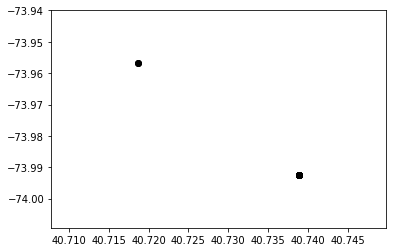

[(40.738933, -73.992373), (40.718639, -73.956914), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.718639, -73.956914), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373)]


In [13]:
user = "116"
x = []
y = []
print(len(user_checkin_history[user]))
for point in user_checkin_history[user]:
    x.append(point.latitude)
    y.append(point.longitude)
plt.scatter(x, y, color='black')
plt.show()
print(user_checkin_history[user])

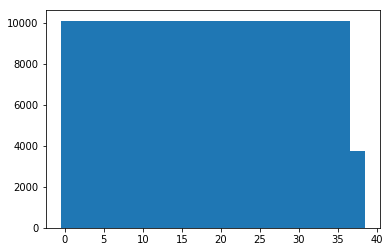

[10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 10100, 3745.372951715338, 3745.372951715338]


In [14]:
POP = POPTICS(user_checkin_history[user], max(len(user_checkin_history[user])//20,3))
GL = POP.run()
#GL = POPTICS(user_checkin_history[user], 50 )
# for cluster in GL:
#     print(cluster.points)
POP.show()

In [15]:
account = 0
color = ["blue", "yellow", "green", "red", "gray"]
for i,cluster in enumerate(GL):
    x = []
    y = []
    account += len(cluster.points)
#     for p in cluster.points:
#         for pp in user_checkin_history[user]:
#             if p == pp:
#                 print(p, pp)
#                 account+=1
    for point in cluster.points:
        x.append(point.latitude)
        y.append(point.longitude)
    print(i)
    plt.scatter(x, y, color = color[i])
    #plt.axis([40.9649, 40.9665, -74.062, -74.064])
plt.show()
print(len(user_checkin_history[user]))
print(account)
print(len(user_checkin_history[user])- account)

39
0
39


In [16]:
user_clusters = defaultdict(list)
for user in users:
    print(user)
    POP = POPTICS(user_checkin_history[user], max(len(user_checkin_history[user])//20,3))
    user_clusters[user] = POP.run()
print("finish")

470
69
87
484
642
428
877
691
116
445
895
704
891
901
699
100
443
689
390
32
230
834
962
1032
525
318
1047
738
364
398
839
424
751
889
612
643
718
768
15
458
280
1016
281
276
80
673
337
916
639
752
713
1012
438
217
656
225
628
504
164
235
118
1054
881
706
143
1005
912
537
868
1055
907
303
793
784
734
540
816
623
294
615
173
16
7
592
636
865
621
272
591
976
562
783
319
468
874
107
667
557
725
880
288
335
769
403
573
346
968
539
184
144
71
688
65
885
267
820
516
176
528
30
246
515
710
145
498
894
313
120
798
1078
195
59
662
553
702
84
129
864
658
951
817
371
121
49
50
29
519
340
391
526
645
758
611
577
984
1025
354
373
902
571
440
987
185
559
279
529
131
207
943
179
444
586
510
1044
572
766
162
299
652
315
637
12
787
633
672
973
597
422
365
805
905
940
359
191
130
186
692
1009
806
1076
842
125
474
26
90
989
139
593
328
402
57
221
198
772
408
818
187
242
994
509
969
861
361
296
826
475
149
54
432
386
626
215
17
1013
848
188
434
14
854
985
1083
415
649
208
619
990
722
1042
480
362
495
1040

In [50]:
pickle.dump(user_clusters, open("user_clusters.pickle", 'wb'))
print("finish")

finish


In [24]:
# import numpy as np
#from scipy.spatial.distance import pdist, squarefrom
# def gaussian(x, mu, sig):
#     return 1/(np.sqrt(2*np.pi*np.power(sig,2)))*np.exp(-np.power((x-mu)/sig, 2)/2)
####################################demand_supply_ratio#########################################################
import math
import pickle
def gaussian_2d(x, y, mu_x, mu_y, sig):
    exp_value = -(np.power(x-mu_x, 2)+np.power(y-mu_y, 2))/(2*np.power(sig, 2))
    return 1/(np.sqrt(2*np.pi*np.power(sig,2)))*np.exp(exp_value)

user_clusters = pickle.load( open("user_clusters.pickle", 'rb') )
#pattern_venue = pickle.load( open("pattern_point.pickle", 'rb') )

# user_clusterID = defaultdict(list)
# for user in user_checkin_history:
#     for p in user_checkin_history[user]:
#         for i,cluster in enumerate(user_clusters[user]):
#             if p in cluster.points:
#                 user_clusterID[user].append(i)
#                 break
#             else:
#                 user_clusterID[user].append(-1)

#print(user_clusterID)
#print(user_clusters)
# #demand level
# venues = [] #[(user1, user2 ...), (user1, user2, ...)]
# venue_user = [] #[venue1(user1, user2 ...), venue2(user1, user2 ...) ...]
# venue_pattern = [] #[pattern1(venue1, venue2, ...)]
venues = []
for user in user_clusters:
    for cluster in user_clusters[user]:
        for p in cluster.points:
            if p not in venues:
                venues.append(p)
            
venue_user = defaultdict(list)
for venue in venues:
#     print(venue)
    for user in user_clusters:
        for cluster in user_clusters[user]:
            if venue in cluster.points:
                venue_user[venues.index(venue)].append(user)
#venue_user format:{venue_index1:[user1, user2...],venue_index2:[user1, user2,...]}
#print(venue_user)

demand = defaultdict(float)
for venue in venue_user:
    demand[venue] = 0
    for user in venue_user[venue]:
        for cluster in user_clusters[user]:
            if venues[venue] in cluster.points:
                this_center = cluster.center
                this_radius = cluster.radius
                d = gaussian_2d(venues[venue].latitude, venues[venue].longitude, this_center.latitude, this_center.longitude, this_radius)
                demand[venue] += d
print(demand)

#demand format:{venue1: demand_value, venue2: demand_value,...}
#total demand
#read dictionary pattern_venue
# totaldemand = defaultdict(float)
# for pattern in pattern_venue:
#     totaldemand[pattern] = 0
#     for venue in venues:
#         if venue in pattern_venue[pattern]:
#             dt = demand[venues.index(venue)]
#             totaldemand[pattern] += dt


2466.928659983256
2466.928659983256
2466.928659983256
2466.928659983256
2466.928659983256
2466.928659983256
104.73977545231216
425.31668890882156
2466.928659983256
2466.928659983256
2466.928659983256
2466.928659983256
2466.928659983256
2466.928659983256
188.9414053661983
2466.928659983256
2446.3489400272115
2466.928659983256
2466.928659983256
2466.928659983256
169.94547668659737
2466.928659983256
2466.928659983256
2466.928659983256
511.0007256709495
2466.928659983256
2466.928659983256
2466.928659983256
2466.928659983256
2466.928659983256
2466.928659983256
1725.3051551885635
2466.928659983256
2466.928659983256
2466.928659983256
2466.928659983256
5883.763846972475
2466.928659983256
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.

1562.570277417929
1562.570277417929
7.012097847196487
7.012097847196487
7.012097847196487
7.012097847196487
22.369700063074152
22.369700063074152
22.369700063074152
22.369700063074152
22.369700063074152
22.369700063074152
22.369700063074152
22.369700063074152
22.369700063074152
22.369700063074152
22.369700063074152
22.369700063074152
22.369700063074152
22.369700063074152
22.369700063074152
22.369700063074152
22.369700063074152
22.369700063074152
22.369700063074152
22.369700063074152
22.369700063074152
22.369700063074152
22.369700063074152
22.369700063074152
65.6761572073197
2384.63973015677
1546.1570738874582
65.6761572073197
1215.9880556551964
283.15628658465755
65.6761572073197
16.031778106553073
16.031778106553073
16.031778106553073
35.50776491781833
35.50776491781833
35.50776491781833
326.79897990433534
326.79897990433534
326.79897990433534
326.79897990433534
326.79897990433534
326.79897990433534
234.58257411800705
234.58257411800705
234.58257411800705
234.58257411800705
234.582574

376.4272064528405
265.5911724706464
181.39756686529176
1679.722593373115
181.39756686529176
181.39756686529176
376.4272064528405
181.39756686529176
181.39756686529176
5.356487651503751
34.655422340431635
34.655422340431635
625.1581063728389
625.1581063728389
625.1581063728389
625.1581063728389
625.1581063728389
266.8798180014796
625.1581063728389
625.1581063728389
190.401249818762
625.1581063728389
3127.277846820293
1254.9345400749671
1206.2434510143542
625.1581063728389
1254.9345400749671
625.1581063728389
3127.277846820293
1679.722593373115
625.1581063728389
1679.722593373115
625.1581063728389
1254.9345400749671
625.1581063728389
1032.39863420126
1040.1268695769752
260.27378607124734
625.1581063728389
268.7262770408964
268.7262770408964
281.6551962553761
268.7262770408964
281.6551962553761
268.7262770408964
268.7262770408964
2384.63973015677
268.7262770408964
107.00739818015914
107.00739818015914
21.613242945545657
21.613242945545657
21.613242945545657
21.613242945545657
19.846746173

863.7453873930621
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1039.2321656978604
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1216.2172493154633
1546.1570738874582
122.05835514408473
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
316.5351086215846
1546.1570738874582
316.5351086215846
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
1546.1570738874582
260.55320769648574
1546.1570738874

In [57]:
#total demand
#read dictionary pattern_venue
# totaldemand = defaultdict(float)
# for pattern in pattern_venue:
#     totaldemand[pattern] = 0
#     for venue in venues:
#         if venue in pattern_venue[pattern]:
#             dt = demand[venues.index(venue)]
#             totaldemand[pattern] += dt


In [14]:
#print(totaldemand)

In [15]:
#defaultdict(<class 'float'>, {1: 6.1842149089561556, 3: 2.9455926757476565, 0: 14.192235860226486, 2: 15.270860094090434, 4: 16.39032580781028, 7: 12.442467252074932, 8: 16.894575702681514, 5: 4.945073418661651, 6: 4.507744411075705})

#output totaldemand[pattern]:
#0: 14.192235860226486
#1: 6.1842149089561556
#2: 15.270860094090434
#3: 2.9455926757476565
#4: 16.39032580781028
#5: 4.945073418661651
#6: 4.507744411075705
#7: 12.442467252074932
#8: 16.894575702681514

In [27]:
#supply level
#standard deviation for supply

def distance(point1, point2):

    # convert coordinates to radians

    p1_lat, p1_lon, p2_lat, p2_lon = [math.radians(c) for c in
        [point1.latitude, point1.longitude, point2.latitude, point2.longitude]]

    numerator = math.sqrt(
        math.pow(math.cos(p2_lat) * math.sin(p2_lon - p1_lon), 2) +
        math.pow(
            math.cos(p1_lat) * math.sin(p2_lat) -
            math.sin(p1_lat) * math.cos(p2_lat) *
            math.cos(p2_lon - p1_lon), 2))

    denominator = (
        math.sin(p1_lat) * math.sin(p2_lat) +
        math.cos(p1_lat) * math.cos(p2_lat) *
        math.cos(p2_lon - p1_lon))

    # convert distance from radians to meters
    # note: earth's radius ~ 6372800 meters

    return math.atan2(numerator, denominator) * 6372800
    
def distance_venue(venue): 
    user_number = 0
    total_dist = 0
    for user in venue_user[venue]: 
        for cluster in user_clusters[user]:
            if venues[venue] in cluster.points:
                u_center = cluster.center
                #print(u_center)
        dist = distance(u_center, venues[venue])
        total_dist += dist
        user_number += 1
    average_dist = total_dist / user_number
    return average_dist

supply = defaultdict(float)
# for venue in venues:
#     #print(venue)
#     supply[venues.index(venue)] = 0
#     for user in venue_user[venues.index(venue)]:
#         for cluster in user_clusters[user]:
#             if venue in cluster.points:
#                 u_center = cluster.center
#                 s = gaussian_2d(u_center.latitude, u_center.longitude, venue.latitude, venue.longitude, distance_venue(venue))
#                 supply[venues.index(venue)] += s
# print(supply)
for venue in venue_user:
    supply[venue] = 0
    for user in venue_user[venue]:
        for cluster in user_clusters[user]:
            if venues[venue] in cluster.points:
                this_center = cluster.center
                #this_radius = cluster.radius
                s = gaussian_2d(venues[venue].latitude, venues[venue].longitude, this_center.latitude, this_center.longitude, distance_venue(venue))
                #print(this_radius)
                supply[venue] += s
print(supply)
# #total supply
# totalsupply = defaultdict(float)
# for pattern in pattern_venue:
#     totalsupply[pattern] = 0
#     for venue in pattern_venue[pattern]:
#         st = supply[venue]
#         totalsupply[pattern] += st

       

defaultdict(<class 'float'>, {0: 0.00028098817413575717, 1: 0.00031613015267616714, 2: 0.0002790627180153378, 3: 0.00035647446423531356, 4: 0.00030302964528304473, 5: 0.003185833075632462, 6: 0.00040090496533484076, 7: 0.0005601616303334443, 8: 0.0005929195776504875, 9: 0.00034512524404576954, 10: 0.0009780610387305042, 11: 0.0021090431189827543, 12: 0.0008460769286698275, 13: 0.00043085544887390024, 14: 0.00034953622515897215, 15: 0.0043479706743292015, 16: 0.00027529838173274903, 17: 0.000585036424561174, 18: 0.0016444694158253173, 19: 0.000499246429837022, 20: 0.0007252472799746928, 21: 0.0004503324399117451, 22: 0.0004248816561068073, 23: 0.00041794889674973146, 24: 0.0006135574506002273, 25: 0.00027852463227958654, 26: 0.00022832826077480854, 27: 0.00021545601290175068, 28: 0.017556227684904654, 29: 0.0015563452098384194, 30: 0.0005609069839599266, 31: 0.0007890484120437224, 32: 0.00046865749620691224, 33: 0.0003617182993860402, 34: 0.0002999288506293684, 35: 0.0002976897912222594

In [29]:
#demand_supply_ratio
dsr = []
for i in range(5273):
    dsr.append(demand[i]/supply[i])
print(dsr)

[0.5755266426140851, 0.5115493701125259, 0.5794976183998792, 0.45365431945391127, 0.5336645539213203, 1.54075709928851, 0.40337784377557534, 0.2886955687768334, 0.27274555702292125, 0.46857244801584697, 0.16534364837441407, 1.077823625687544, 0.38388091522230705, 0.3753374383403331, 0.46265928631830083, 0.5770941339650592, 0.5874214714053247, 0.27642070422773146, 0.5730869946904805, 0.32392055468266095, 0.2229807473142268, 0.35910399994093006, 0.38061464445747734, 0.38692811904366364, 0.6404390694455425, 0.5806171581695226, 0.7082617803183809, 0.7505763162260292, 0.026146859019542185, 0.04356612157641635, 0.12088265356931113, 0.08593126048002338, 0.14467692328708273, 0.18744952838066106, 0.22606669709900043, 0.2277670468579668, 0.4007584057550061, 0.29475216099334567, 0.2506813102381611, 0.1610921370681959, 0.2342268856817434, 0.2961822067191008, 0.37102158431061205, 0.33183162804394734, 0.4912117323539335, 0.2128067646156657, 0.7689652741068521, 0.8291105588754908, 0.8230727153152108,

In [20]:
# #user_clusters.pickle
# import pickle
# dd = pickle.load( open("user_clusters.pickle", 'rb') )
# print(dd)

In [20]:
# import pickle
# pattern_point = pickle.load(open("pattern_point.pickle", "rb"))
# #format: {pattern0: [p1, p2, ...]} pattern 0 - 8
# #print(pattern_point[0][0])